In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gensim
import nltk
import re
import spacy
import en_core_web_sm
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import unicodedata
import regex as rx
import qgrid

from tqdm import tqdm
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from nltk.stem import WordNetLemmatizer, SnowballStemmer

C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) > LooseVersion('0.20.0'):
C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) > LooseVersion('0.20.0'):
C:\Users\dominik\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:573: DeprecationWarning: metadata {'sync': True} was set from the constructor. With traitlets 4.1, metadata should be set using t

In [2]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
data = pd.read_csv('C:/Users/dominik/Desktop/Uni/Masterthesis/Data/Outputs/Scrape/220705_html_content_normalized.csv', sep=',')
data = data.sample(frac=1, random_state = 1)

In [4]:
data

,links,html_content,word_count
723,https://ethereals.wtf/#team,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,212
1012,https://superplastic.co/collections/frontpage/...,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,12
1683,https://eulerbeats.com/,Drops\nStake\nDocs\nContact\nFutura is here!\n...,140
1717,https://www.coolcatsnft.com/competition-rules/...,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,2863
1695,https://www.divineanarchy.com/edition-3-the-bu...,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,426
...,...,...,...
715,https://nfp.daz3d.com/frequently-asked-questions,NFPets\nPartnerships\nUtility\nRoadmap\nTeam\n...,221
905,https://www.dgenesis.io/collections/prime/drips,ARBIDRIPS MINT FOR BRIDGEOOORS IS NOW LIVE - M...,673
1096,https://0xadventures.com/,Adventure Cards\nDiscord\nOpensea\nTwitter\nCo...,82
235,https://tubbycats.club/@ratwell,Profilverzeichnis\nÜber diesen Server\nMobile ...,230


In [5]:
documents = data['html_content']
documents = pd.DataFrame(documents)

In [6]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

def remove_sandl_words(s,s_count,l_count):
    return ' '.join([w for w in s.split() if len(w)>s_count and len(w)<l_count])

In [7]:
def preprocess(df):

    # remove html tags from data
    df['text_preprocessed'] = df.iloc[:, 0].str.replace(r"->","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"<-","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"[","<")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"]",">")
    df['text_preprocessed'] = df.iloc[:, 1].apply(cleanhtml)

    #remove control characters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\p{C}', ' ',x))
    
    #remove emails
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\S*@\S*\s?', '',x))
    
    # remove punctuation
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: re.sub(r'[,\.!?]', '', x))

    # remove words shorter than 3
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: remove_sandl_words(x,2,20))
    
    # change to lowercase letters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: x.lower())
    
    return df

In [8]:
documents = preprocess(documents)

In [9]:
documents["word_count"] = documents['text_preprocessed'].str.split().str.len()

In [10]:
documents.head()

,html_content,text_preprocessed,word_count
723,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,home story roadmap team nft basics faq discord...,175
1012,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,default title add bag case blindboxes single b...,9
1683,Drops\nStake\nDocs\nContact\nFutura is here!\n...,drops stake docs contact futura here futura th...,113
1717,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,connect cool cats candy bucket giveaway rules ...,2340
1695,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,about faq news play now edition the bureau hel...,348


In [11]:
documents = documents[documents["word_count"]<10000]

In [12]:
num_words = documents["word_count"].sum()

In [13]:
num_words

698042

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

In [15]:
data = documents.text_preprocessed.values.tolist()
documents_words = list(sent_to_words(data))

In [16]:
# Build the bigram models
bigram = gensim.models.Phrases(documents_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [17]:
stop_words = stopwords.words('english')

stop_words.extend(stopwords.words('german'))

stop_words.extend(['blockchain','bitcoin','ethereum','technology','nft','nfts','mint','javascript','terms','condition','websites','terms','service'
                   ,'website','cookie','impressum','imprint','etc','cookies'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(documents_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 1500000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['home', 'story', 'roadmap', 'team', 'basic', 'buy', 'shop', 'contact', 'eth', 'minting', 'est', 'origin', 'wormhole', 'sheet', 'ethereal', 'fun', 'park', 'operator', 'chaos', 'operator', 'etherealtron', 'win', 'create', 'playing', 'explore', 'sharing', 'make', 'ethereal', 'artist', 'ghost', 'active', 'player', 'community', 'painstakingly', 'draw', 'ethereal', 'hand', 'digitize', 'creator', 'banana', 'know', 'hyper', 'realistic', 'oil', 'painting', 'toy', 'pop_culture', 'icon', 'work', 'feature', 'private', 'collection', 'world', 'collaboration', 'brand', 'converse', 'work', 'feature', 'major', 'industry', 'publication', 'forbe', 'lead', 'artist', 'warhodl', 'marketing', 'strategy', 'support', 'event', 'planning', 'event', 'partnership', 'bayc', 'hodler', 'marketing', 'community', 'head', 'market', 'social_media', 'strategist', 'event', 'manager', 'bayc', 'hodler', 'mnmlty', 'project', 'management', 'product', 'development', 'lead', 'developer', 'laser', 'falcon', 'brand', 'developmen

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 3), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 4), (25, 1), (26, 3), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1)]]


In [22]:
words_total = 0
for t in texts:
    x = len(t)
    words_total = words_total + x

In [23]:
words_total

351614

In [24]:
from multiprocessing import Process, freeze_support
if __name__ == "__main__":
    freeze_support()
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=8, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    # Print the Keyword in the 8 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

[(0,
  '0.037*"information" + 0.026*"use" + 0.024*"datum" + 0.019*"personal" + '
  '0.012*"collect" + 0.010*"include" + 0.010*"right" + 0.009*"provide" + '
  '0.009*"email" + 0.009*"service"'),
 (1,
  '0.017*"collection" + 0.014*"art" + 0.010*"create" + 0.009*"token" + '
  '0.009*"project" + 0.008*"artist" + 0.007*"holder" + 0.007*"unique" + '
  '0.007*"community" + 0.007*"rtfkt"'),
 (2,
  '0.032*"claim" + 0.024*"set" + 0.017*"buy" + 0.015*"product" + 0.012*"order" '
  '+ 0.011*"blocknumber_number" + 0.010*"wallet" + 0.010*"phase" + '
  '0.010*"metaverse" + 0.009*"gmoney"'),
 (3,
  '0.015*"game" + 0.008*"community" + 0.008*"world" + 0.006*"team" + '
  '0.006*"metaverse" + 0.005*"new" + 0.005*"get" + 0.005*"build" + '
  '0.005*"play" + 0.005*"wallet"'),
 (4,
  '0.146*"infinite" + 0.028*"infinite_irl" + 0.010*"cryptopunk" + '
  '0.009*"metasaur" + 0.008*"superlativess_superlativess" + 0.007*"white" + '
  '0.007*"body" + 0.007*"search" + 0.007*"color" + 0.006*"meebit"'),
 (5,
  '0.038*"ar

In [25]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                                  dictionary=id2word, 
                                                      coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5027008569531897


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

    coherence_values = []
    model_list = []

    for n_topics in tqdm(range(start, limit+1, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics= n_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
total_num_topics = 20
models, cvalues = compute_coherence_values(id2word,corpus,texts,total_num_topics)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [10:45<00:00, 33.96s/it]


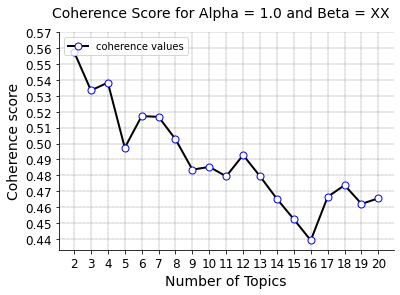

In [28]:
# Show graph
limit=total_num_topics; start=2; step=1;
x = range(start, limit+1, step)
y = cvalues

# predefine the graph results 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [12.00, 6.00]
#plt.rcParams["figure.autolayout"] = True
ticksize = 12
labelsize = 14
markersize = 7
markercolor = 'blue'

#plot the graph
plt.plot(x, y, color='black', linestyle='-', linewidth = 2,
         marker='o', markerfacecolor='white', markeredgecolor=markercolor, markersize=markersize, label ="coherence values")

# define range on axes
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize = ticksize)
plt.yticks(np.arange(round(min(y),2), max(y)+0.02, 0.01), fontsize = ticksize)

# name axes
plt.xlabel("Number of Topics", fontsize = labelsize)
plt.ylabel("Coherence score", fontsize = labelsize)

# title & legend
plt.suptitle("Coherence Score for Alpha = 1.0 and Beta = XX", fontsize = 14, y = 0.97)
plt.legend(loc='upper left')

#remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

#grid
plt.grid(color = 'black',which = 'both', linestyle = '--', linewidth = 0.25)

# print plot
plt.show()

In [29]:
def compute_coherence_values_a(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.11))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.11))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=len(alpha)*len(beta))
    
    # iterate through validation corpuses
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=7, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(7)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 69%|███████████████████████████████████████████████████████▉                         | 76/110 [39:02<16:40, 29.42s/it]

In [ ]:
model_res = pd.DataFrame(model_results)
model_res.sort_values(by = ['Coherence'],ascending = False)

In [ ]:
best_alpha = 0.89
best_beta = 0.12
best_num_top = 8

final_LDA_a = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=best_num_top, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=best_alpha,
                                           eta=best_beta)
pprint(final_LDA_a.print_topics())

coherence_LDA_a = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=best_num_top, a=best_alpha, b=best_beta)

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

topic_data2 = pyLDAvis.gensim_models.prepare(final_LDA_a, corpus, id2word) 
topic_data2

In [ ]:
pyLDAvis.save_html(topic_data2, '220711_pyLDA_NFT_Nouns.html')

In [ ]:
all_topics = {}
num_terms = 20 # Adjust number of words to represent each topic
lambd = 0.5 # Adjust this accordingly based on tuning above
for i in range(1,best_num_top+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data2.topic_info[topic_data2.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [ ]:
topic_words = pd.DataFrame(all_topics).T

In [ ]:
topic_words

In [ ]:
topic_words.to_csv("C:/Users/dominik/Desktop/Uni/Masterthesis/Data/Outputs/LDA/220707_topic_words_a.csv")

In [ ]:
# tabelize data to display in thesis
table_data = {
    "Model":["LDA_a"],
    "Words initial":[num_words],
    "Words after preprocess":[words_total],
    "Number of Topics":[best_num_top],
    "LDA Alpha":[best_alpha],
    "LDA Beta":[best_beta],
    "LDA coherrence":[coherence_LDA_a],
    "LDA Lambda":[lambd]
    }

table_inf = pd.DataFrame(table_data)

In [ ]:
table_inf